# Text analysis of YouTube dataset

***

## Task: can we find a set of words which are common to videos which are quick-to-trend, but not common to videos which are slow-to-trend? 

### Motivation: if we can find a set of words which distinguishes videos which begin trending quickly compared to those which begin trending slowly, we could suggest adding certain words to your title/tags/descriptions to increase the probability of your video trending quickly. It may also allow us to estimate how long it will take for a given video to begin trending at the moment it is posted, when we have no other data. 

### Strategy:

1. Prepare data 
    - Consider only UK, CA and US datasets. 
    - Consider categories separately.
    - Calculate time between publication of a video and when it first begins to trend.
    
2. Identify a set of words which may occur more freqently in titles/descriptions/tags of quick-to-trend videos, but not in slow-to-trend videos.
    - Take the subset of quickest to trending videos. For example, those which trend the same day as they are posted.
    - Find which words are most common to the titles/tag/description (document) of the quickest to trend videos. That is, find which words occur in the most documents in the subset, not how many times a word occurs in a given document.
    - Rank these words from most common to least common. Then choose the first n words, there are our n most common words, common to the videos which trend on the same day they are posted.
    - __Note__, this is a postulate of what the set of words which distinguish the two catergories would be. Other methods which assign feature importance, such as using a tf-idf weighting, does not assign importance to words in the way we need. 
    
3. Use a statistical hypothesis test to determine if these words occur more frequently in quick-to-trend videos than in slow-to-trend videos.
    - Calculate the combined term frequency of our n common words in each document in the set of quick-to-trend videos. This is: (the number of occurances of common words found in the document) / (the total number of words in the document).
    - Calculate the combined term frequency of our n common words in each document in the set of slow-to-trend videos.
    - Check if the mean value of the combined term frequency for quick-to-trend videos is different than the mean value of the combined term frequency for slow-to-trend videos. See if this difference is statistically significant using a t-test.
    - If the difference is statistically significant, we will have identified a set of words which is common to douments describing occurs more frequently in quick-to-trending videos but not in slow-to-trend videos.
    - __Note__ this method does not claim causality, only that these words occur more frequently in videos that trend in quick-to-trend videos than in slow-to-trend videos.
 

4. Draw insights from the test & discuss limitations and improvements.
 - Using the method described below it does seem possible to identify a set of words which occurs more frequenly in 'quick-to-trend'; the method was applied to video titles in the Entertainment category. 
 - Key insights: 
     - Promo videos and trailers appear to trend quickest.
     - People look for authenticity.
     - People look for the most recent version of a video.
     - American Idol appears to be the most popular tv show in this category. 
     - Celebrity 'gossip' appears to trend quickly.
     - iPhone announcements appear to trend quickly. 

 
 ***

#### Load and organise data

In [426]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

import re
import string
import nltk
from nltk.corpus import stopwords

from scipy import stats

from sklearn.feature_extraction.text import CountVectorizer

In [427]:
gb = pd.read_csv('GBvideos.csv')
ca = pd.read_csv('CAvideos.csv')
us = pd.read_csv('USvideos.csv')

#Extract categories from json files
with open("GB_category_id.json") as f:
    categories = json.load(f)["items"]
cat_dict = {}
for cat in categories:
    cat_dict[int(cat["id"])] = cat["snippet"]["title"]
gb['category_name'] = gb['category_id'].map(cat_dict)


with open("CA_category_id.json") as f:
    categories = json.load(f)["items"]
cat_dict = {}
for cat in categories:
    cat_dict[int(cat["id"])] = cat["snippet"]["title"]
ca['category_name'] = ca['category_id'].map(cat_dict)


with open("US_category_id.json") as f:
    categories = json.load(f)["items"]
cat_dict = {}
for cat in categories:
    cat_dict[int(cat["id"])] = cat["snippet"]["title"]
us['category_name'] = us['category_id'].map(cat_dict)

In [428]:
'''Create column which keeps track of country after merging datasets.
We can map integers to the strings representing the countrys by 
representing them as enumerations.'''

from enum import Enum
class Country(Enum):
    gb = 0
    ca = 1
    us = 2
    
gb['country'] = Country(0)
ca['country'] = Country(1)
us['country'] = Country(2)

In [429]:

print(gb.shape)
print(us.shape)
print(ca.shape)

(38916, 18)
(40949, 18)
(40881, 18)


In [430]:
data = pd.concat([gb,ca,us],axis=0).reset_index(drop=True) #drop=True stops Pandas from adding old indexes as a new column
print(data.shape)

(120746, 18)


In [424]:
print(data[data['country']==Country.gb].shape)

(3272, 19)


In [226]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120746 entries, 0 to 120745
Data columns (total 18 columns):
video_id                  120746 non-null object
trending_date             120746 non-null object
title                     120746 non-null object
channel_title             120746 non-null object
category_id               120746 non-null int64
publish_time              120746 non-null object
tags                      120746 non-null object
views                     120746 non-null int64
likes                     120746 non-null int64
dislikes                  120746 non-null int64
comment_count             120746 non-null int64
thumbnail_link            120746 non-null object
comments_disabled         120746 non-null bool
ratings_disabled          120746 non-null bool
video_error_or_removed    120746 non-null bool
description               118268 non-null object
category_name             120582 non-null object
country                   120746 non-null object
dtypes: bool(3), i

__Note__ some decriptions and categories are missing. 

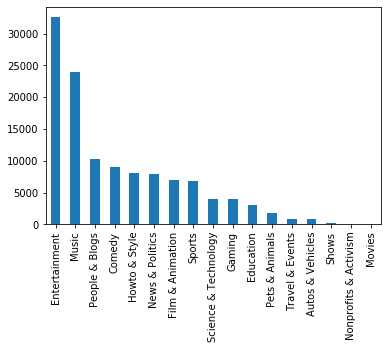

In [227]:
'''Create bar chart to see which countries have largest
number of trending videos in combined dataset.

Note that each country has different categories so the total
number of categories here is different to the amount of 
categories in the individual data sets.'''

category_counts= data['category_name'].value_counts()
fig = plt.figure()
category_counts.plot.bar()
plt.show()

#### Calculate the time between publication and trending

First step is to filter out duplicate instances, and keep only first instance of each video, when it began trending.

In [228]:
data = data.drop_duplicates(subset='video_id',keep='first').reset_index(drop=True)

In [229]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30318 entries, 0 to 30317
Data columns (total 18 columns):
video_id                  30318 non-null object
trending_date             30318 non-null object
title                     30318 non-null object
channel_title             30318 non-null object
category_id               30318 non-null int64
publish_time              30318 non-null object
tags                      30318 non-null object
views                     30318 non-null int64
likes                     30318 non-null int64
dislikes                  30318 non-null int64
comment_count             30318 non-null int64
thumbnail_link            30318 non-null object
comments_disabled         30318 non-null bool
ratings_disabled          30318 non-null bool
video_error_or_removed    30318 non-null bool
description               29227 non-null object
category_name             30264 non-null object
country                   30318 non-null object
dtypes: bool(3), int64(5), object(10)


In [230]:
'''The datetime packages allows us to conventiatly do arithmetic with date objects.'''
from datetime import date

In [231]:
def published_date(string):
    
    '''This function is specfic for the string format
    in this dataset.
    
    Input:
        string: string of published datae
        
    Algorithm:
        Split string at letter 'T' and then split at '-'.
        This returns a list containing the year, month and day.
        Convert strings to int type.
        Create date object instance with format (year,month,day)
        
    Returns:
        datetime.date object containing the date of publication.'''
    
    date_string = string.split('T')[0].split('-') # split into list containing strings
    return date(int(date_string[0]),int(date_string[1]),int(date_string[2])) #return datetime object (year,month,day)

In [232]:
def trending_date(string):
    
    '''This function is specfic for the string format
    in this dataset.
    
    Input:
        string: string of published datae
        
    Algorithm:
        Split string at '.'.
        This returns a list containing the year, month and day.
        Change year from '00xx' to '20xx' (eg. 0017 to 2017).
        Convert strings to int type.
        Create date object instance with format (year,month,day)
        
    Returns:
        datetime.date object containing the date of publication.'''
        
    trend_string = string.split('.')
    trend_string[0] = '20'+trend_string[0]
    return date(int(trend_string[0]),int(trend_string[2]),int(trend_string[1]))
    #return trend_string

In [233]:
'''test published_date()'''
#pub_time = data['publish_time']
#x = pub_time[0]
#x = published_date(x)
#print(x)

In [234]:
'''test trending_date()'''
#trend_time = data['trending_date']
#y = trend_time[8]
#y = trending_date(y)
#print(y)

In [235]:
'''calculate difference between dates'''
#number of days is contained in the days attribute of the date class
#delta = y-x
#delta_days = delta.days
#print(delta_days)
#print(type(delta_days))

In [236]:
#Transform the published time column and trending time column.
#Not interested in originals so just overwrite columns.
data['publish_time'] = data['publish_time'].apply(published_date)
data['trending_date'] = data['trending_date'].apply(trending_date)

In [237]:
#check transformation
print(type(data['publish_time'][0]))

<class 'datetime.date'>


In [239]:
print(type(data['publish_time'][0]))


<class 'datetime.date'>


In [240]:
#create column which contains the number of days it took to trend

data['days_till_trending'] = data['trending_date'] - data['publish_time'] #gives a column of data objects
data['days_till_trending'] = data['days_till_trending'].apply(lambda x: x.days) #extracts the number of days from date object


In [241]:
print(data['days_till_trending'])
print(data['days_till_trending'].describe())


0        4
1        2
2        4
3        1
4        1
        ..
30313    1
30314    0
30315    1
30316    2
30317    1
Name: days_till_trending, Length: 30318, dtype: int64
count    30318.000000
mean        10.656607
std        140.509067
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max       4215.000000
Name: days_till_trending, dtype: float64


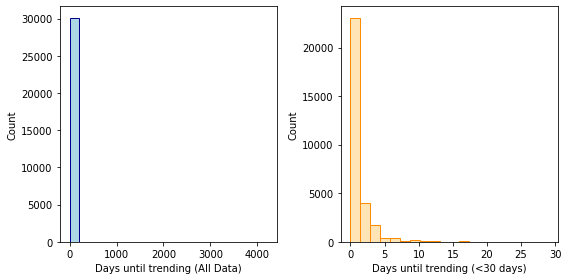

In [244]:
#Visualise the distribution of times taken to begin trending 

fig,ax = plt.subplots(1,2,figsize=(8,4))
times = data['days_till_trending']
times_truncated = times.values[np.where(times<30)]
ax[0].hist(times,facecolor='lightblue',bins=20,ec='darkblue')
ax[1].hist(times_truncated,facecolor='moccasin',bins=20,ec='darkorange')
ax[0].set_xlabel('Days until trending (All Data)')
ax[1].set_xlabel('Days until trending (<30 days)')
ax[0].set_ylabel('Count')
ax[1].set_ylabel('Count')
plt.tight_layout()
plt.show()

In [250]:
for i in range(10):
    days = data[data['days_till_trending']==i]
    print('Number videos trending after '+str(i)+' days:', days.shape[0])


#zero_days = data[data['days_till_trending']==0].reset_index(drop=True)
#one_days = data[data['days_till_trending']==1].reset_index(drop=True)
#two_days = data[data['days_till_trending']==2].reset_index(drop=True)

#print('Number videos trending after 0 days:', zero_days.shape[0])
#print('Number videos trending after 1 days:', one_days.shape[0])
#print('Number videos trending after 2 days:', two_days.shape[0])

Number videos trending after 0 days: 2065
Number videos trending after 1 days: 21015
Number videos trending after 2 days: 3991
Number videos trending after 3 days: 1116
Number videos trending after 4 days: 583
Number videos trending after 5 days: 362
Number videos trending after 6 days: 212
Number videos trending after 7 days: 158
Number videos trending after 8 days: 97
Number videos trending after 9 days: 89


We have a good idea of how the number of days it takes for a video to begin trending. The distribution has positive skew, however the number of videos trending after 0 days is approximaley 10 times smaller than the number of videos trending after 1 day. After 1 day the number of videos trending begins to decrease. 54% of all trendning videos take 1 day to begin trending. This gives an initial insight: __it becomes less likely your video will trend every day past the day after you publish your video__. 

#### Which category has the most trending videos after 0, 1 and 2 days?

It is likely that any words which may distinguish which videos trend quickly from those which do not are category specific, so we should check which categorys have the most videos which begin to trend quickly and if this changes over time.

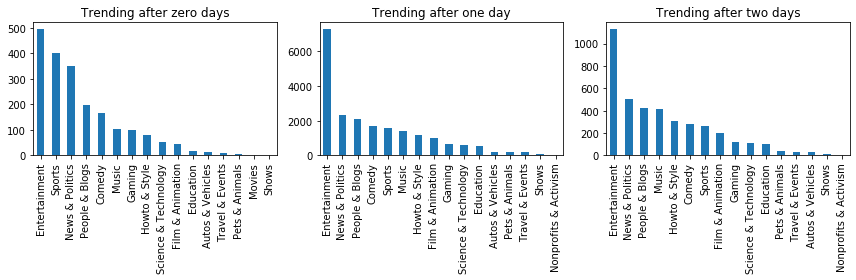

In [268]:
zero_days = data[data['days_till_trending']==0].reset_index(drop=True)
one_days = data[data['days_till_trending']==1].reset_index(drop=True)
two_days = data[data['days_till_trending']==2].reset_index(drop=True)

category_counts_zero= zero_days['category_name'].value_counts()
category_counts_one= one_days['category_name'].value_counts()
category_counts_two= two_days['category_name'].value_counts()

fig,ax = plt.subplots(1,3,figsize=(12,4))
category_counts_zero.plot.bar(ax=ax[0])
category_counts_one.plot.bar(ax=ax[1])
category_counts_two.plot.bar(ax=ax[2])
ax[0].set_title('Trending after zero days')
ax[1].set_title('Trending after one day')
ax[2].set_title('Trending after two days')
plt.tight_layout()
plt.show()

Entertainment consistantly has the most trending videos after 0, 1 and 2 days. Initially, sports is second but overtaken by News & Politics and People & Blogs after 1 day and then Music, Howto & Style and Comedy after 2 days. __This suggests that sports videos trend on the day when the event happens__, but other categories require a day or two some time to gain traction, while the Entertainiment category consistently has the most trending videos.


Since Entertainment constantly has the highest number of trending videos, lets look at just the entertainemtn category first, so simplify the analysis.

#### Looking for words common to the quick-to-trend videos in the Enertainment category

In [274]:
ent_data = data[data['category_name']=='Entertainment'].reset_index(drop=True)
ent_fast = ent_data[ent_data['days_till_trending']==0].reset_index(drop=True)
ent_slow = ent_data[ent_data['days_till_trending']!=0].reset_index(drop=True)
print(ent_data.shape)
print(ent_fast.shape)
print(ent_slow.shape)

(9730, 19)
(497, 19)
(9233, 19)


For now we will look at just those that trend on the same day they are posted. We can have a look at 0 and 1 days after.

To look at the most common words which may hold significance we do the following steps:
 - Clean the documents. From EDA it is known that there are hyper-links, non-latin scripts, numerical characters, special characters, and symbols contained in all document types (titles/descriptions/tags). We will remove these along with common stop words.
 - Use CountVectorizer to create a sparse matrix containing the occurace of each word in the vocabulary in every document in the corpus. 
 - Count the number of non zero elements in each column of the sparse matrix. This will be the number of documents in the corpus that each word is found. The result will be an 1xn array where n is the number of words in the vocabulary and each element is the number of documents each word is found in
 - Sort this to find the most commonly occuring words.


Consider title, descriptions and tags separately.

In [276]:
print(ent_fast.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497 entries, 0 to 496
Data columns (total 19 columns):
video_id                  497 non-null object
trending_date             497 non-null object
title                     497 non-null object
channel_title             497 non-null object
category_id               497 non-null int64
publish_time              497 non-null object
tags                      497 non-null object
views                     497 non-null int64
likes                     497 non-null int64
dislikes                  497 non-null int64
comment_count             497 non-null int64
thumbnail_link            497 non-null object
comments_disabled         497 non-null bool
ratings_disabled          497 non-null bool
video_error_or_removed    497 non-null bool
description               486 non-null object
category_name             497 non-null object
country                   497 non-null object
days_till_trending        497 non-null int64
dtypes: bool(3), int64(6), object

In [279]:
'''This function was developed during EDA and the steps are described inside the function body. The function does
not employ stemming and contains names/words which are not standard English words. There are also some non-English, 
European words. The presence of 'non-standard' English words is probably Ok when we just want to use the
CountVectorizer as a convenient method to represent words before finding the most common, since these one-off 
words will likely be specific to a given document and wont be among the most popular. 

Stemming may or may not help: it will help of stemming is succesful and reduces the number of words, which is more 
likely for the titles and tags, where there is less slang/shorthand. If it overstems/understems however, we may
begin to create more noise in the data. This could happen with descriptions where there is more slang/shorthand.'''

def text_normalise(message):
    
    '''Input: string
    
    1) Remove any links.
    2) Remove any Asian characters.
    3) Remove words length 3 or less, these tend to be special character such as \n, single numerical digits
    and generally unimportant words.
    4) Remove punctuation and return a list of strings.
    5) Make all words lower-case and remove stopwords from list.
    
    Returns: list of strings'''
    
    message = re.sub(r"http\S+", "", str(message)) #remove any links
    message = re.sub("([^\x00-\x7F])+"," ",str(message)) #remove any non-latin characters
    message = message.replace('\\n',' ') #remove new line special charatcer
    message = re.sub(r'\b\w{1,3}\b', '', message) # remove all words length 3 or less
    no_punc = ''.join([char for char in message if char not in string.punctuation]) #remove punctuation return list of string
    no_stopwords = [word.lower() for word in no_punc.split() if word.lower() not in stopwords.words('english')] #remove stopwords
    return no_stopwords

### Looking for common words in the titles 

In [288]:
title_fast = ent_fast['title']
title_fast = title_fast.apply(text_normalise)
print(title_fast)
print(title_fast.shape)

0                               [last, gasp, jedi, rant]
1      [trust, last, jedi, love, letter, star, wars, ...
2                                  [jumanji, 1995, 2017]
3             [half, episode, maze, runner, death, cure]
4            [tide, super, bowl, 2018, commercial, tide]
                             ...                        
492      [john, legend, tony, bennett, sing, york, york]
493                     [mobile, littleones, 2018, game]
494    [monster, super, bowl, commercial, extended, v...
495    [padma, lakshmi, topchef, cancer, diagnosis, w...
496           [nashville, final, episodes, coming, june]
Name: title, Length: 497, dtype: object


In [367]:
#drop empty lists
print(title_fast.shape)
title_fast = title_fast[title_fast.str.len()!=0] #remove empty lists from series
print(title_fast.shape)

(497,)
(489,)


In [368]:
#create the matrix counting word occurances. 
#not we can combine this step with the previous step using CountVectorizers analyzer. 
transformer = CountVectorizer(analyzer=text_normalise).fit(ent_fast['title'])

In [369]:
matrix = transformer.transform(ent_fast['title'])

In [370]:
print(matrix.shape)

(497, 1543)


The words in all documents is represented by a 497x1543 matrix. The number of rows comes from the 497 documents in the dataset. 1543 is the total number of words in the vocabulary. We proceed by calculating the number of non zero elements in each column. Be careful to keep track of row indicies, since we need to use these to map back to the orignal words. 

In [371]:
occurances = np.count_nonzero(matrix.toarray(),axis=0)
sorted_occurances = np.sort(occurances) #gives array in ascending order
sorted_indices = np.argsort(occurances) #gives corresponding counts in ascending order

sorted_occurances = sorted_occurances[::-1] #flip array
sorted_indices = sorted_indices[::-1] #flip corresponding indices
print(np.argmax(occurances))
print(sorted_occurances[:33])
print(sorted_indices)

17
[86 58 51 26 26 22 17 16 16 14 13 12 11 11 10 10 10 10  9  9  9  9  9  9
  9  9  9  8  8  8  8  8  8]
[  17  477 1218 ...  950  952    0]


After fitting the Countvectorizer we get a vocabulary. This is a dictionary which has the words as keys and the values are the feature indices, that is, the index of each word in the vocaulary. In order to use the index to look up the word, we need to swap all the key value pairs, so that the index becomes the key and the word becomes the value.

In [372]:
orginal_vocabulary = transformer.vocabulary_
#print(orginal_vocabulary)
swapped_vocabulary =  dict((v,k) for k,v in orginal_vocabulary.items())


In [373]:
#top 30 most common words 
top_30_indices = sorted_indices[:30]
print(top_30_indices)
top_30_words = [swapped_vocabulary[i] for i in top_30_indices]
print(top_30_words)

[  17  477 1218 1070   16  815  665   93 1482  522  529 1421  578 1403
 1474  688 1347 1114  916 1015  817  280  976   92  103  631 1255 1232
  494  831]
['2018', 'episode', 'season', 'promo', '2017', 'live', 'idol', 'american', 'voice', 'finale', 'flash', 'trailer', 'girls', 'tlmep', 'video', 'iphone', 'super', 'recap', 'monologue', 'paul', 'logan', 'chicken', 'official', 'america', 'annie', 'hayden', 'show', 'series', 'extended', 'love']


Now we have the top 30 words we get the term frequency for each video

#### Calculating the Combined Term Frequency in the quick-to-trend videos

In [411]:
'''Define new class object so we can create a frequency counter for any set of common words
we will then be able to apply instances of this class to columns of our datasets using the
apply() method.'''

class FreqCounter:
    
    def __init__(self,common_words):
        self.c = common_words #list of common words


    def __call__(self,document):
        
        '''Calculates frequency of most common words in a document.

        Inputs:
            common_word_list: list of common words
            document: list of strings
        Output:
            frequency: the proportion of the document made up
            of elements from the common word list.'''
    
        common_words = self.c

        count = sum(el in common_words for el in document)
        return count/len(document)
        
    def test_FreqCounter():
        
        '''This is used to test if the above callable 
        works as intended, by testing it on a simple
        pair of lists with a known result.'''
        
        word = ['cat','no']
        doc = ['cat','cat','no','top','sea','no','fish','cow']
        
        '''The combined term freqency of the strings 'cat' and 'no'
        in the list doc is (2+2)/8= 0.5. We test that the callable
        indeed returns 0.5.'''
        
        fc = FreqCounter(word)
        assert abs(fc(doc)-0.5)<1e-10, 'Function not returning expected value of 0.5. Check __call__(document).'

In [413]:
#test FreqCounter on simple lists 
#this will raise an Assertion error is the test function is not satisfied.
#if it works as expected this will return None
print(FreqCounter.test_FreqCounter())

None


In [387]:
freq_counter = FreqCounter(top_30_words)
freq_fast = title_fast.apply(freq_counter) #the frequency of common words occuring in the videos that trend after 0 days
print(freq_fast)

0      0.000000
1      0.125000
2      0.333333
3      0.166667
4      0.333333
         ...   
492    0.000000
493    0.250000
494    0.333333
495    0.000000
496    0.000000
Name: title, Length: 489, dtype: float64


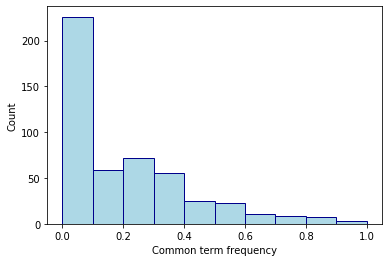

Mean combined term frequency: 0.18012107751371553


In [391]:
fig = plt.figure()
plt.hist(freq_fast.values,facecolor='lightblue',ec='darkblue')
plt.xlabel('Common term frequency')
plt.ylabel('Count')
plt.show()

print('Mean combined term frequency:', np.mean(freq_fast.values))

Now, calculate frequency of the same set of words in the data set of videos that are slow to trend and compare the mean values.
#### Calculating the Combined Term Frequency in the slow-to-trend videos

In [396]:
title_slow = ent_slow['title'] #get titles of slow to trend videos 
title_slow = title_slow.apply(text_normalise) #normalise the titles
title_slow = title_slow[title_slow.str.len()!=0] #remove empty documents
freq_slow = title_slow.apply(freq_counter) #calculate the combined term frequencies using the FreqCounter instance


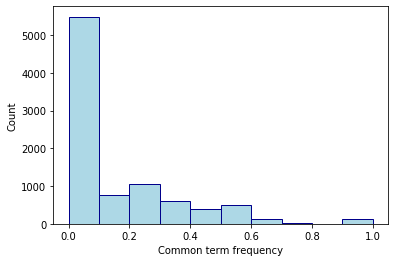

Mean combined term frequency: 0.13310746132029058


In [397]:
fig = plt.figure()
plt.hist(freq_slow.values,facecolor='lightblue',ec='darkblue')
plt.xlabel('Common term frequency')
plt.ylabel('Count')
plt.show()

print('Mean combined term frequency:', np.mean(freq_slow.values))

#### Use Student's t-test to see if means are significantly different.
 - __Note__ although the two distributions are skewed, the validity of the t-test relies on the assumption that the __t-statistic itself__ follows a normal distribution, not the distribution of the population (our data) is normal. The distribution of t-statistic is obtained by __sampling from the population__ and by the central limit theorem, this distribution will be normal if the number of samples is high enough. 'High enough' is commonly taken to be more than approximately 50 points, so our data satisfies this condition. The upshot is, a t-test is valid, even though the distributions of the combined term frequencies are skewed.
 


In [403]:
#Check how similar the varience of the two groups are
print('Varience of quick-to-trend:', np.var(freq_fast.values,ddof=1))
print('Varience of slow-to-trend:', np.var(freq_slow.values,ddof=1))
print('Ratio:', np.var(freq_fast.values,ddof=1)/np.var(freq_slow.values,ddof=1))

Varience of quick-to-trend: 0.04653303231007048
Varience of slow-to-trend: 0.041144853466525924
Ratio: 1.130956325994166


We have similar varience and non equal sample sizes. We can use stats.ttest_ind(x1,x2) to calculate the t-statistic and p-value. By default it assums varience is equal and that sample sizes are not equal.



In [405]:
test_result = stats.ttest_ind(freq_fast.values,freq_slow.values)
print(test_result)


Ttest_indResult(statistic=4.9759345267940125, pvalue=6.606524778237355e-07)


The p-value is much smaller than any chosen significance level, often chosen to be 0.05, which indicates that this result is statistically significant. We can calculate the magnitude of the difference in terms of the pooled standard deviation. This metric is called Cohen's d.

In [414]:
def pooled_std(g1, g2):
    'Compute the pooled standard devation of two independent 1D arrays'

    n1 = g1.shape[0]
    n2 = g2.shape[0]
    var1 = np.var(g1,ddof=1)
    var2 = np.var(g2,ddof=1)
    
    pooled_std = np.sqrt(((n1-1)*var1 + (n2-1)*var2)/(n1 + n2 - 2))
    
    return pooled_std

def cohens_d(g1, g2,s):
    'Compute Cohens d'
    
    return (np.mean(g1)-np.mean(g2))/s

In [415]:
std = pooled_std(freq_fast.values,freq_slow.values)
d = cohens_d(freq_fast.values,freq_slow.values,std)
print(d)

0.2310038095177387


### Interpretation of t-test results

- We have identified a set of words which are commonly found in titles which trend on the same day as they are posted. __Note__ this word selection was not based on how frequently it occurs in any given title, only on how many titles in the group it occured in. 
- We then calculated how frequently these words occured in video titles in both groups the videos that trend on the same day as publication and those that do not. We called this the __combined term frequency__.
- We compared the mean value of the combined term frequency in both groups using a statistical hypothesis test (t-test).
- The resulting p-value was 6.6 $\times$ 10$^{-7}$, which is smaller than any significance level which would commonly be used. This means that the mean value of the combines term frequency in the two groups __is significantly different__, that is, we almost certainly __do not observe this difference by chance__.
- The difference between the mean combined term frequencies is 0.23 times the pooled standard deviation, this is considered a small difference, although it is significant.
- Therefore, we have indentified a set of words which occur more frequently in the titles of videos which trend in the same day than in titles of videos which do not trend on the same day.
- This process has only been applied to video titles in the Enterainment category, we could apply the same method to identify sets of words occuring in the descriptions or tags and in other categories. 


## Insights from this result

The top 30 words which appear more frequently in quick-to-trend videos are shown below:

In [417]:
print(top_30_words)

['2018', 'episode', 'season', 'promo', '2017', 'live', 'idol', 'american', 'voice', 'finale', 'flash', 'trailer', 'girls', 'tlmep', 'video', 'iphone', 'super', 'recap', 'monologue', 'paul', 'logan', 'chicken', 'official', 'america', 'annie', 'hayden', 'show', 'series', 'extended', 'love']


We can idenfity some known TV shows and people in this set:
 - American Idol (TV show)
 - Logan Paul (Youtuber)
 - Annie & Hayden (likely relates to two, famous US child actors with millions of instagram followers, who 'broke-up' in 2018).
 
And words which relate to TV and film in general:
 - Episode
 - Season
 - Promo 
 - Official 
 - Trailer 
 - Series
 - Video

1. From this data set it seems that in the Entertainment category, __promo videos and trailers__ trend on the day they are posted.
2. The appreance of 'Official' suggests that __people look for authenticity__ with their videos. You can imagine this would occur in prahses such as 'Official Trailer' and 'Official Promo'.
3. The appearance of '2018' and '2017' suggests that __people look for the most current version__ of specific videos.
3. It suggests that American idol is the most popular show in the category and the audience engages with new videos on the day of posting.
4. Celebrities may trend quickly. Logan Paul is often known to be controversial, this suggests that __controversy could cause videos to begin trending faster__. Also a google search of Annie Hayden brings up multiple hits relating to the break-up of the two US actors mentioned above. This suggests that __celebrity 'gossip' also trends quickly__.
5. __iPhone announcments trend quickly__, which may be expected since Apple is known to have a dedicated customer base. The occurance of 'iphone' could relate to the announcement of the release of the iPhone XS, XS Max and XR in 2018. 


## Limitations and improvements

This section has developed a method for identifying words which may be helpful in distingusishing which videos trend on the same day that they are posted. It has been applied to the titles of videos in the entertainment category here, but could be applied to any set of documents so long as:

- There are enough videos in that category in order to satisfy the normality assumtion of the t-test. Without the t-test we can't say that the words we have identified as being important truly do occur more frequently in titles of videos that trend on the same day. 
- Most of the data is in English. This method cannot currently distinguish other languages and scripts.

Improvements:
 - In order to apply this method to more categories and document types, we would want to automate the process. To do this you would create custom Scikit-learn transformers for each transformation step and then join them using a Pipeline. 
 - Further investiagtion into the text cleaning function. Could stemming help? Could removing non-English, European langues help?

Potential applications:
 - Could we use the combined term frequencies as a predictor variable, to classify a video into quick-to-trend or slow-to-trend.
 - If we were using the combined term frequencies generated by this process to classify videos, we would probably want to define some hyperparameters. For example how many words do we include in our top n most common words? Where do we define the boundary between quick-to-trend and slow-to-trend, could including videos which trend after 1 day in the quick-to-trend data set give better classification performance? We could optimise these parameters using a grid search. 